In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as pl
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error
from sklearn import tree, svm
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
#from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('./ML/bez_trip_id_a_timestamp.csv')

In [3]:
df.head()

,calculated_delay,delay_stop_departure,hour,minute,day_of_week,speed,distance_traveled,trip_delay,section_last_delay,section_avg_delay
0,205,198,23,5,4,7,57.3,242,268,214
1,-67,-22,23,5,4,21,36.6,90,125,201
2,45,43,23,5,4,23,27.3,0,7,61
3,113,166,23,5,4,55,18.3,30,277,79
4,255,239,23,5,4,33,20.9,8,356,305


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863314 entries, 0 to 10863313
Data columns (total 10 columns):
calculated_delay        int64
delay_stop_departure    int64
hour                    int64
minute                  int64
day_of_week             int64
speed                   int64
distance_traveled       float64
trip_delay              int64
section_last_delay      int64
section_avg_delay       int64
dtypes: float64(1), int64(9)
memory usage: 828.8 MB


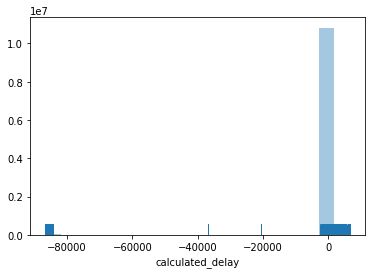

In [7]:
fig = sns.distplot(df['calculated_delay'], bins=20, kde = False, rug=True)
fig.get_figure().savefig('calculated_delay_distribution.png')

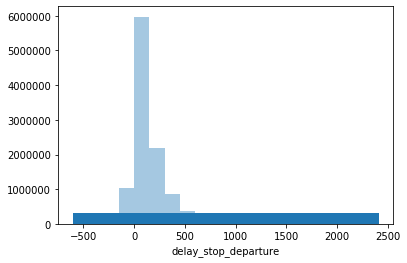

In [5]:
fig_2 = sns.distplot(df['delay_stop_departure'], bins=20, kde = False, rug=True)
fig_2.get_figure().savefig('delay_stop_departure_distr.png')

In [6]:
df.describe()

,calculated_delay,delay_stop_departure,hour,minute,day_of_week,speed,distance_traveled,trip_delay,section_last_delay,section_avg_delay
count,1.086331e+07,1.086331e+07,1.086331e+07,1.086331e+07,1.086331e+07,1.086331e+07,1.086331e+07,1.086331e+07,1.086331e+07,1.086331e+07
mean,-6.293476e+01,1.539429e+02,1.174717e+01,2.948051e+01,3.578772e+00,2.996750e+01,1.207330e+01,7.974908e+01,1.604717e+02,1.264131e+02
std,4.338557e+03,2.095885e+02,5.059448e+00,1.729529e+01,1.795433e+00,2.276382e+01,1.133600e+01,1.105582e+02,2.114124e+02,1.448300e+02
min,-8.666300e+04,-6.000000e+02,0.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,-1.570000e+02,-5.950000e+02,-4.210000e+02
25%,2.300000e+01,2.900000e+01,7.000000e+00,1.500000e+01,2.000000e+00,1.100000e+01,3.600000e+00,3.000000e+00,3.300000e+01,2.900000e+01
50%,9.300000e+01,9.300000e+01,1.200000e+01,2.900000e+01,4.000000e+00,3.000000e+01,8.800000e+00,4.200000e+01,1.010000e+02,8.200000e+01
75%,2.130000e+02,2.080000e+02,1.600000e+01,4.400000e+01,5.000000e+00,4.500000e+01,1.730000e+01,1.110000e+02,2.180000e+02,1.730000e+02
max,6.522000e+03,2.400000e+03,2.300000e+01,5.900000e+01,7.000000e+00,3.040000e+02,6.830000e+01,2.311000e+03,2.398000e+03,2.384000e+03


In [3]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [4]:
df = remove_outlier(df, 'calculated_delay')
df = remove_outlier(df, 'delay_stop_departure')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9809330 entries, 0 to 10863313
Data columns (total 10 columns):
calculated_delay        int64
delay_stop_departure    int64
hour                    int64
minute                  int64
day_of_week             int64
speed                   int64
distance_traveled       float64
trip_delay              int64
section_last_delay      int64
section_avg_delay       int64
dtypes: float64(1), int64(9)
memory usage: 823.2 MB


In [13]:
df.describe()

,calculated_delay,delay_stop_departure,hour,minute,day_of_week,speed,distance_traveled,trip_delay,section_last_delay,section_avg_delay
count,9.809330e+06,9.809330e+06,9.809330e+06,9.809330e+06,9.809330e+06,9.809330e+06,9.809330e+06,9.809330e+06,9.809330e+06,9.809330e+06
mean,1.017177e+02,1.053668e+02,1.169496e+01,2.952974e+01,3.606374e+00,3.002444e+01,1.133457e+01,6.337520e+01,1.362285e+02,1.018281e+02
std,1.149295e+02,1.065491e+02,5.094760e+00,1.727480e+01,1.806250e+00,2.265729e+01,1.088599e+01,8.377568e+01,1.730849e+02,1.055651e+02
min,-2.610000e+02,-2.040000e+02,2.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,-1.570000e+02,-5.950000e+02,-2.930000e+02
25%,1.800000e+01,2.400000e+01,7.000000e+00,1.500000e+01,2.000000e+00,1.100000e+01,3.300000e+00,1.000000e+00,3.000000e+01,2.500000e+01
50%,7.800000e+01,8.000000e+01,1.200000e+01,3.000000e+01,4.000000e+00,3.100000e+01,8.100000e+00,3.500000e+01,9.100000e+01,7.300000e+01
75%,1.700000e+02,1.680000e+02,1.600000e+01,4.500000e+01,5.000000e+00,4.500000e+01,1.610000e+01,9.300000e+01,1.910000e+02,1.460000e+02
max,4.970000e+02,4.100000e+02,2.300000e+01,5.900000e+01,7.000000e+00,3.040000e+02,6.830000e+01,1.914000e+03,2.398000e+03,1.837000e+03


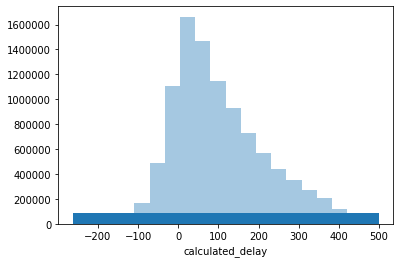

In [23]:
fig = sns.distplot(df['calculated_delay'], bins=20, kde = False, rug=True)
fig.get_figure().savefig('calculated_delay_distribution_after.png')

In [29]:
pl.close()

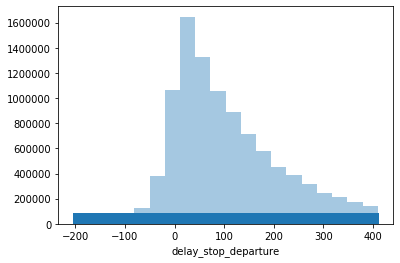

In [27]:
fig = sns.distplot(df['delay_stop_departure'], bins=20, kde = False, rug=True)
fig.get_figure().savefig('delay_stop_departure_distr_after.png')

In [5]:
X = df.drop('delay_stop_departure', axis=1)
y = df['delay_stop_departure']

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40)

# Tree regressor

In [12]:
clf = tree.DecisionTreeRegressor()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('{};{};{}'.format(mean_absolute_error(y_test, y_pred), median_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

22.475358828139065;10.0;1701.3463507188153


In [13]:
from sklearn import tree
print('n;mean_absolute_error;median_absolute_error;mean_squared_error')
for n in range(1,15):
    clf = tree.DecisionTreeRegressor(max_depth=n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{};{};{};{}'.format(n,mean_absolute_error(y_test, y_pred), median_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

n;mean_absolute_error;median_absolute_error;mean_squared_error
1;52.396526864106946;42.695089630361196;4558.644288071018
2;35.7475631746695;25.917842707802034;2660.6696724235717
3;30.40864732177475;19.316845043814148;2178.719228136738
4;27.61023521553049;17.18677955447295;1905.8517233488492
5;26.211428079308305;15.343311899026496;1787.83263187458
6;25.666405352653783;15.245629952216802;1723.7987794059197
7;24.977727189176907;14.362835893486817;1666.8941220279228
8;24.70741920204798;14.368955791218902;1627.8004700142947
9;24.552840274089803;14.35472476472863;1595.658009791175
10;24.338997288339492;14.351477250973147;1562.9201317099732
11;24.091239824102825;14.194764546877224;1530.50731394911
12;23.8515737023407;14.041595794031252;1497.015710157472
13;23.63128489254406;13.982565379825658;1468.3844662292558
14;23.371352305568195;13.810736026563376;1438.0966449066937


In [24]:
from sklearn import tree
print('n;mean_absolute_error;median_absolute_error;mean_squared_error')
for n in range(15,25):
    clf = tree.DecisionTreeRegressor(max_depth=n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{};{};{};{}'.format(n,mean_absolute_error(y_test, y_pred), median_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

n;mean_absolute_error;median_absolute_error;mean_squared_error
15;23.10098726090825;13.694183073955202;1407.144091884346
16;22.867678386869027;13.544400144980074;1387.7614224077636
17;22.630594434183116;13.370265151515127;1372.1519529059326
18;22.400498567644245;13.189966433820194;1361.0857342405025
19;22.19345792313317;12.968777103209021;1358.5476019278244
20;22.02061832858087;12.753424657534254;1361.441434649544
21;21.879117219782128;12.509895227008144;1371.518971262997
22;21.78178338141676;12.282089552238801;1387.6490488745605
23;21.72125966398723;12.025641025641029;1407.2997534267606
24;21.71286440795633;11.833333333333336;1434.3987567886431


In [25]:
from sklearn import tree
print('n;mean_absolute_error;median_absolute_error;mean_squared_error')
for n in range(25,40):
    clf = tree.DecisionTreeRegressor(max_depth=n)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{};{};{};{}'.format(n,mean_absolute_error(y_test, y_pred), median_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

n;mean_absolute_error;median_absolute_error;mean_squared_error
25;21.73569264072418;11.579999999999998;1464.5049559474323
26;21.76019417511536;11.333333333333343;1489.8823829786566
27;21.82547805785497;11.08923076923077;1519.1538238639578
28;21.90693609958853;11.0;1549.7304556111103
29;21.973350170777138;10.8840579710145;1570.5250293261638
30;22.04506098967468;10.666666666666671;1592.157465801417


KeyboardInterrupt: 

In [31]:
pickle.dump(clf, open('./ML/decision_tree_regressor.model', 'wb'))

# KNN regressor

In [ ]:
print('n;mean_absolute_error;median_absolute_error;mean_squared_error')
for n in range(1,16,2):
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print('{};{};{};{}'.format(n,mean_absolute_error(y_test, y_pred), median_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

n;mean_absolute_error;median_absolute_error;mean_squared_error
1;17.175460250598157;5.0;1242.2022148811386
3;19.23400893163279;10.666666666666657;1092.6976991689435
5;20.151534406529287;11.799999999999997;1115.2781719240766
7;20.84957564452849;12.428571428571427;1149.4555481404757
9;21.35224837532794;12.888888888888886;1179.9872158306632
11;21.68554438849174;13.181818181818182;1205.6431650903482
13;21.923544923361405;13.30769230769232;1226.507918023245


In [15]:
print('n;mean_absolute_error;median_absolute_error;mean_squared_error')
for n in range(1,100,10):
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    print('{};{};{};{}'.format(n,mean_absolute_error(y_test, y_pred), median_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)))

n;mean_absolute_error;median_absolute_error;mean_squared_error
1;17.17202321667229;5.0;1242.4057797525418
11;21.67816708916179;13.181818181818182;1206.242772402136
21;22.4722359684485;13.714285714285708;1285.823372923297
31;22.816905501717372;13.83870967741936;1330.4399048457137
41;23.023787638165178;13.902439024390247;1359.7999130769322
51;23.170047756454675;13.941176470588236;1381.2149776947183
61;23.278222967484957;13.967213114754102;1398.1908155668966
71;23.36846746708215;14.0;1412.1806438407255


KeyboardInterrupt: 

22.467556803423015
10.0


# Linear regression

In [29]:
from sklearn import linear_model

In [33]:
reg = linear_model.LinearRegression(normalize=True)
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [34]:
y_pred_lin_reg = reg.predict(X_test)

In [35]:
print(mean_absolute_error(y_test, y_pred_lin_reg))
print(median_absolute_error(y_test, y_pred_lin_reg))
print(mean_squared_error(y_test, y_pred_lin_reg))

28.402678572770427
18.431057519559467
1991.71954245067


In [43]:
reg = linear_model.Ridge(alpha=.9)
reg.fit(X_train, y_train)

Ridge(alpha=0.9, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [44]:
y_pred_lin_reg = reg.predict(X_test)

In [45]:
print(mean_absolute_error(y_test, y_pred_lin_reg))
print(median_absolute_error(y_test, y_pred_lin_reg))
print(mean_squared_error(y_test, y_pred_lin_reg))

28.402678572794308
18.431057516928362
1991.7195424487845


In [46]:
clf = linear_model.BayesianRidge()
clf.fit(X_train, y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

In [49]:
y_pred_lin_reg = clf.predict(X_test)

In [50]:
print(mean_absolute_error(y_test, y_pred_lin_reg))
print(median_absolute_error(y_test, y_pred_lin_reg))
print(mean_squared_error(y_test, y_pred_lin_reg))

28.402679179387626
18.431091591046126
1991.7194911704557


# Gradient boosting regressor

In [15]:

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls', verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1       10062.8815            7.37m
         2        9002.8105            7.26m
         3        8102.7757            7.14m
         4        7348.1632            7.08m
         5        6696.3374            7.01m
         6        6144.5510            6.93m
         7        5661.9811            6.86m
         8        5250.2580            6.79m
         9        4887.3888            6.74m
        10        4576.1085            6.67m
        20        2892.4490            5.91m
        30        2312.3942            5.17m
        40        2069.1676            4.44m
        50        1953.7955            3.69m
        60        1895.9279            2.95m
        70        1865.7500            2.21m
        80        1847.2643            1.47m
        90        1832.8829           44.01s
       100        1821.4785            0.00s


In [33]:
pickle.dump(est, open('./ML/GradientBoostingRegressor.model', 'wb'))

In [16]:
y_pred_grad_boost = est.predict(X_test)

In [17]:
print(mean_absolute_error(y_test, y_pred_grad_boost))
print(median_absolute_error(y_test, y_pred_grad_boost))

26.87183879682102
16.82312707151108


In [18]:

ada_boost_reg = AdaBoostRegressor(loss='square')
ada_boost_reg.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='square',
                  n_estimators=50, random_state=None)

In [34]:
pickle.dump(ada_boost_reg, open('./ML/AdaBoostRegressor.model', 'wb'))

# ADA boost regressor

In [21]:
y_pred_ada_boost = ada_boost_reg.predict(X_test)

In [22]:
print(mean_absolute_error(y_test, y_pred_ada_boost))
print(median_absolute_error(y_test, y_pred_ada_boost))

74.79193155762712
63.54510503280004


# Neural network

In [18]:
1 hidden lazer
mlp_1h_layer = MLPRegressor(hidden_layer_sizes=(5), activation='relu', solver='adam', max_iter=200, verbose=True)
mlp_1h_layer.fit(X_train,y_train)

Iteration 1, loss = 919.78161289
Iteration 2, loss = 870.92511823
Iteration 3, loss = 867.56004125
Iteration 4, loss = 865.26721097
Iteration 5, loss = 863.25831776
Iteration 6, loss = 861.72080759
Iteration 7, loss = 860.43953181
Iteration 8, loss = 859.30390661
Iteration 9, loss = 858.37279277
Iteration 10, loss = 857.65232223
Iteration 11, loss = 856.85088143
Iteration 12, loss = 856.29471377
Iteration 13, loss = 855.67558563
Iteration 14, loss = 855.23809091
Iteration 15, loss = 854.88635257
Iteration 16, loss = 854.35874005
Iteration 17, loss = 854.03183950


/home/kerb/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning:

Training interrupted by user.



MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=5, learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=True,
             warm_start=False)

In [13]:
# 2 hidden layers
mlp = MLPRegressor(hidden_layer_sizes=(10,5), activation='relu', solver='adam', max_iter=100, verbose=True)
mlp.fit(X_train,y_train)

Iteration 1, loss = 896.88517342
Iteration 2, loss = 836.10482156
Iteration 3, loss = 831.04679108
Iteration 4, loss = 827.32197407
Iteration 5, loss = 824.68208082
Iteration 6, loss = 823.06584850
Iteration 7, loss = 821.09353486
Iteration 8, loss = 818.31058406
Iteration 9, loss = 814.71534199
Iteration 10, loss = 811.23785218
Iteration 11, loss = 809.05754552
Iteration 12, loss = 808.23045436
Iteration 13, loss = 807.01857493
Iteration 14, loss = 806.29692549
Iteration 15, loss = 805.58054579
Iteration 16, loss = 805.04175906
Iteration 17, loss = 804.47446108
Iteration 18, loss = 804.15554719
Iteration 19, loss = 803.27421042
Iteration 20, loss = 802.66718796
Iteration 21, loss = 802.23180810
Iteration 22, loss = 801.63599507
Iteration 23, loss = 800.91182386
Iteration 24, loss = 800.35572000
Iteration 25, loss = 799.98215714
Iteration 26, loss = 799.30047550
Iteration 27, loss = 798.93823852
Iteration 28, loss = 798.67535908
Iteration 29, loss = 798.20698181
Iteration 30, loss = 79

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 5), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=500,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=True,
             warm_start=False)

In [14]:
y_pred_nn = mlp.predict(X_test)

In [16]:
print(mean_absolute_error(y_test, y_pred_nn))
print(median_absolute_error(y_test, y_pred_nn))
print(mean_squared_error(y_test, y_pred_nn))

24.60833591371755
14.488412114337557
1576.2963050096637


In [19]:
# 3 hidden layers
mlp_3h_layers = MLPRegressor(hidden_layer_sizes=(10, 5, 3), activation='relu', solver='adam', max_iter=100, verbose=True)
mlp_3h_layers.fit(X_train,y_train)

Iteration 1, loss = 920.21067591
Iteration 2, loss = 827.74133941
Iteration 3, loss = 824.38678405
Iteration 4, loss = 822.07191846
Iteration 5, loss = 819.36172214
Iteration 6, loss = 816.46997711
Iteration 7, loss = 814.33182539
Iteration 8, loss = 812.46412094
Iteration 9, loss = 810.24274241
Iteration 10, loss = 807.24193407
Iteration 11, loss = 803.47286911
Iteration 12, loss = 800.28122849
Iteration 13, loss = 798.77490605
Iteration 14, loss = 797.12941475
Iteration 15, loss = 796.30681558
Iteration 16, loss = 795.81158228
Iteration 17, loss = 795.20300098
Iteration 18, loss = 794.74527786
Iteration 19, loss = 794.57654325
Iteration 20, loss = 794.46259659
Iteration 21, loss = 794.00320044
Iteration 22, loss = 794.10357832
Iteration 23, loss = 793.18683994
Iteration 24, loss = 793.64557443
Iteration 25, loss = 793.33717031
Iteration 26, loss = 793.47438018
Iteration 27, loss = 792.97615091
Iteration 28, loss = 793.28506471
Iteration 29, loss = 792.77714313
Iteration 30, loss = 79

/home/kerb/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 5, 3), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=100,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=True,
             warm_start=False)

In [22]:
y_pred_nn_3h = mlp_3h_layers.predict(X_test)

In [23]:
print(mean_absolute_error(y_test, y_pred_nn_3h))
print(median_absolute_error(y_test, y_pred_nn_3h))
print(mean_squared_error(y_test, y_pred_nn_3h))

24.32057371249346
14.200736453773903
1565.8072169370423


In [26]:
# 3 hidden layers
mlp_4h_layers = MLPRegressor(hidden_layer_sizes=(10, 7, 5, 3), activation='relu', solver='adam', max_iter=200, verbose=True)
mlp_4h_layers.fit(X_train,y_train)

Iteration 1, loss = 876.31221747
Iteration 2, loss = 829.62562835
Iteration 3, loss = 826.05174127
Iteration 4, loss = 823.57759986
Iteration 5, loss = 820.81208830
Iteration 6, loss = 816.71443739
Iteration 7, loss = 812.31290002
Iteration 8, loss = 810.05878490
Iteration 9, loss = 808.76323522
Iteration 10, loss = 806.61506179
Iteration 11, loss = 804.95220288
Iteration 12, loss = 804.15665898
Iteration 13, loss = 802.93698999
Iteration 14, loss = 801.26855102
Iteration 15, loss = 800.06712119
Iteration 16, loss = 799.03707329
Iteration 17, loss = 798.52100451
Iteration 18, loss = 798.06156829
Iteration 19, loss = 797.62290700
Iteration 20, loss = 797.37693031
Iteration 21, loss = 796.99568845
Iteration 22, loss = 796.76764563
Iteration 23, loss = 796.36266208
Iteration 24, loss = 796.09035408
Iteration 25, loss = 795.86312140
Iteration 26, loss = 795.60023048
Iteration 27, loss = 795.28933543
Iteration 28, loss = 794.87308496
Iteration 29, loss = 794.91506874
Iteration 30, loss = 79

/home/kerb/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 7, 5, 3), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=True,
             warm_start=False)

In [27]:
y_pred_nn_4h = mlp_4h_layers.predict(X_test)

In [28]:
print(mean_absolute_error(y_test, y_pred_nn_4h))
print(median_absolute_error(y_test, y_pred_nn_4h))
print(mean_squared_error(y_test, y_pred_nn_4h))

24.93060758250108
15.234262345823954
1565.080445333145


# SVR

In [ ]:
clf_svr = svm.SVR(verbose=True)
clf_svr.fit(X_train,y_train)

[LibSVM]

In [ ]:
y_pred_svr = clf_svr.predict(X_test)

In [ ]:
print(mean_absolute_error(y_test, y_pred_svr))
print(median_absolute_error(y_test, y_pred_svr))
print(mean_squared_error(y_test, y_pred_svr))